In [44]:
from medmnist import PathMNIST
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dataset_train = PathMNIST(split='train', download=True)
dataset_test = PathMNIST(split='test', download=True)
dataset_val = PathMNIST(split='val', download=True)

100%|██████████| 205615438/205615438 [00:42<00:00, 4833520.01it/s] 


Using downloaded and verified file: /Users/ramx/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/ramx/.medmnist/pathmnist.npz


#### Exploring the data:

In [3]:
print("Dataset lengths, train:{} - test:{} - val:{}".format(len(dataset_train), len(dataset_test), len(dataset_val)))
print("Shape and type of each object: {}, {}".format(len(dataset_train[0]), type(dataset_train[0])))
print("Shape and type of image: {}, {}".format(np.array(dataset_train[0][0]).shape, type(dataset_train[0][0])))
print("Shape and type of label: {}, {}".format(dataset_train[0][1].shape, type(dataset_train[0][1])))

Dataset lengths, train:89996 - test:7180 - val:10004
Shape and type of each object: 2, <class 'tuple'>
Shape and type of image: (28, 28, 3), <class 'PIL.Image.Image'>
Shape and type of label: (1,), <class 'numpy.ndarray'>


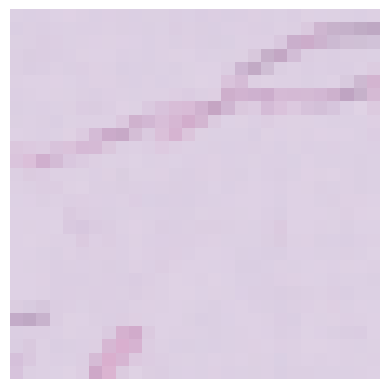

In [7]:
# Get the first image from the training set
first_image = dataset_train[0][0]

# Plot the image
plt.imshow(first_image)
plt.axis('off')
plt.show()


#### Preping the dta for training
- Merge training and validation into "train_val_images" and "train_val_labels"
- Extract data and labels into separate numpy arrays

In [9]:
dataset_train_val = dataset_train + dataset_val
train_val_images = np.array([np.array(dataset_train_val[n][0]) for n in range(len(dataset_train_val))])
train_val_labels = np.array([np.array(dataset_train_val[n][1]) for n in range(len(dataset_train_val))])
test_images = np.array([np.array(dataset_test[n][0]) for n in range(len(dataset_test))])
test_labels = np.array([np.array(dataset_test[n][1]) for n in range(len(dataset_test))])

- It can be seen that the labels are now integers 

In [14]:
display(train_val_labels.min())
display(train_val_labels.max())
display(train_val_labels[:5])

0

8

array([[0],
       [4],
       [7],
       [5],
       [5]])

- Images have the 3 RGB channels, we could convert to Black and White but the hue may be important for the classification

In [22]:
display(train_val_images.shape)

(100000, 28, 28, 3)

#### First exploratory model:

In [23]:
model_CNN = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3), padding='same', strides=1),
    # layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(9, activation='softmax') # Softmax is used for multiclass classification
])

In [24]:
model_CNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # SparseCategoricalCrossentropy is used for multiclass classification with integer labels
              metrics=['accuracy'])

# Train the CNN model
training_CNN = model_CNN.fit(x=train_val_images, y=train_val_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=0) 

In [28]:
y_eval_CNN = model_CNN.evaluate(test_images, test_labels, verbose=0)
display(f"Convolutional NN evaluation score: {y_eval_CNN[1]}")

'Convolutional NN evaluation score: 0.6000000238418579'

In [26]:
y_pred_CNN = model_CNN.predict(test_images)

225/225 [==============================] - 1s 3ms/step


In [27]:
display(y_pred_CNN[:10])
display(test_labels[:10])

array([[1.92410516e-06, 2.35304502e-11, 5.50155900e-02, 7.56942836e-06,
        2.65348759e-02, 3.09030235e-01, 1.99619025e-01, 1.10979518e-02,
        3.98692816e-01],
       [2.95152701e-02, 6.11575233e-05, 1.67010315e-02, 5.99245774e-04,
        7.14727819e-01, 1.18322410e-01, 5.17212525e-02, 5.25400154e-02,
        1.58117991e-02],
       [2.58447289e-01, 4.21708822e-01, 1.22097717e-03, 8.75253318e-06,
        2.95462757e-01, 1.46831460e-02, 2.60664965e-03, 1.69010484e-03,
        4.17152233e-03],
       [7.42340781e-05, 5.70244574e-10, 1.19907930e-01, 2.62010038e-01,
        1.03948582e-02, 9.13021937e-02, 2.51832187e-01, 1.30642116e-01,
        1.33836433e-01],
       [5.80256805e-02, 2.44016526e-04, 1.45486388e-02, 9.57982493e-08,
        1.14102498e-01, 4.23374772e-02, 4.14320640e-02, 3.74152551e-05,
        7.29272127e-01],
       [2.86684871e-01, 6.04543742e-03, 1.40506536e-05, 1.11948623e-07,
        7.07249165e-01, 8.86493157e-10, 6.18769036e-07, 3.64466882e-06,
        2.0

array([[8],
       [4],
       [4],
       [8],
       [4],
       [4],
       [8],
       [0],
       [6],
       [8]])

#### Hyperparameter Tunning:

- Now using Random Search instead of Grid Search

In [47]:
def create_CNN_model(num_layers=1, nodes=64, activation='relu', learning_rate=0.001):
    model = tf.keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3), input_shape=(28, 28, 3)))
        else:
            model.add(layers.Conv2D(nodes, activation=activation, kernel_size=(3, 3)))
    # model.add(layers.MaxPool2D()),
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tune_model(X, y, param_distributions):
    model = KerasClassifier(build_fn=create_CNN_model, verbose=0)
    rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=5)
    rand_search.fit(X, y)
    return rand_search.best_params_, rand_search.best_score_

param_distributions = {'num_layers': [3, 4, 5], 'nodes':[32], 'activation': ['relu', 'tanh'], 'batch_size': [32], 
              'epochs': [5, 8, 11], 'learning_rate': [0.001]}

In [41]:
# from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# def tune_model(X, y, param_grid):
#     model = KerasClassifier(build_fn=create_CNN_model, verbose=0)
#     rand_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=5)
#     rand_search.fit(X, y)
#     return rand_search.best_params_, rand_search.best_score_


In [48]:
best_params, best_score = tune_model(train_val_images, train_val_labels, param_distributions)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

/var/folders/x5/lk3vcxsd1ybc_z4fyxmp024h0000gn/T/ipykernel_55574/4179812120.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_CNN_model, verbose=0)


Best Parameters: {'num_layers': 5, 'nodes': 32, 'learning_rate': 0.001, 'epochs': 11, 'batch_size': 32, 'activation': 'relu'}
Best Score: 0.6627199947834015


Create an optimal model according with the previous hyperparameter tunning:


In [49]:
optimal_model = create_CNN_model(num_layers=5, nodes=32, activation='relu', learning_rate=0.001)
optimal_model.fit(train_val_images, train_val_labels, epochs=11, batch_size=32, validation_split=0.2, verbose=0)
optimal_eval = optimal_model.evaluate(test_images, test_labels, verbose=1)
display(f"Optimal CNN evaluation score: {optimal_eval[1]}")

225/225 [==============================] - 2s 7ms/step - loss: 0.7044 - accuracy: 0.8074


'Optimal CNN evaluation score: 0.8073816299438477'

Run early stopping for further tunning of Epochs:

In [46]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

early_stopping_model = create_CNN_model(num_layers=3, nodes=32, activation='tanh', learning_rate=0.001)
early_stopping_model.fit(train_val_images, train_val_labels, epochs=15, batch_size=64, callbacks=[monitor_val_acc], validation_split=0.2, verbose=1)
optimal_eval = early_stopping_model.evaluate(test_images, test_labels, verbose=1)
display(f"Optimal CNN evaluation score: {optimal_eval[1]}")

Epoch 1/15
1250/1250 [==============================] - 82s 65ms/step - loss: 1.4774 - accuracy: 0.4490 - val_loss: 1.2483 - val_accuracy: 0.5051
Epoch 2/15
1250/1250 [==============================] - 81s 65ms/step - loss: 1.2128 - accuracy: 0.5445 - val_loss: 1.3836 - val_accuracy: 0.5093
Epoch 3/15
1250/1250 [==============================] - 72s 58ms/step - loss: 1.1088 - accuracy: 0.5859 - val_loss: 1.1310 - val_accuracy: 0.5828
Epoch 4/15
1250/1250 [==============================] - 70s 56ms/step - loss: 1.0734 - accuracy: 0.6025 - val_loss: 1.4081 - val_accuracy: 0.5017
Epoch 5/15
1250/1250 [==============================] - 72s 58ms/step - loss: 1.0399 - accuracy: 0.6162 - val_loss: 1.2669 - val_accuracy: 0.5692
Epoch 6/15
1250/1250 [==============================] - 74s 59ms/step - loss: 1.0078 - accuracy: 0.6319 - val_loss: 1.2643 - val_accuracy: 0.5857
Epoch 7/15
1250/1250 [==============================] - 73s 58ms/step - loss: 0.9776 - accuracy: 0.6457 - val_loss: 1.1977 -

'Optimal CNN evaluation score: 0.6491643190383911'